In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [ ]:
# 指定當前的工作資料夾
import os
# 此處為google drive中的檔案路徑,drive為之前指定的工作根目錄，要加上
os.chdir("drive/Colab Notebooks")

In [ ]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
import numpy
from numpy import concatenate
import pandas as pd
import time
import numpy as np

Using TensorFlow backend.


In [ ]:
# 當前時間
start = time.time()

In [ ]:
# load dataset 
def parser(x):
    return datetime.strptime(x, '%Y/%m/%d')                                      # datetime.strptime 函数来定義日期格式

series = read_csv('wheat_200910-201803.csv', header=0, parse_dates=[0],index_col=0, squeeze=True, date_parser=parser)
# https://www.cnblogs.com/datablog/p/6127000.html (read_csv參數介紹)
# header(=0,第一row做為col name)
# parse_dates(指定csv中日期序列,True每個去找,False不找,[0]代表指定第一個為col name)
# index_col(=0,第一col做為row name)
# squeeze(如果只包含一col則返回一個Series)
# date_parser(用於解析日期的函數,parser為自訂義)                                      
series.columns = ['open', 'high', 'low', 'close']
series

In [ ]:
# 以每周五重新採樣(W每周-FRI星期五)
series = series.resample('W-FRI').last()           # last從後面開始
# 移除最後一周(最後一周不是禮拜五)
series = series.drop(series.tail(1).index)
series.tail()

In [ ]:
# 將data轉為固定值
# 轉成差值
def difference(dataset, interval=1):                                             # dataset,interval(時間間隔)
    diff = list()
    for i in range(interval, len(dataset)):                                      # 固定間隔下,這次價格-上次價格的差
        value = dataset[i] - dataset[i - interval]                               # 假設間隔為1, value1 = dataset[1] - dataset[0] value2 = dataset[2] - dataset[1]
        diff.append(value)
    return numpy.array(diff)

raw_values = series.values                       # 讀series的值
close_values = raw_values[:,-1]                  # 讀raw_values的收盤價
diff_values = difference(raw_values, 1)          # 自訂義,讀series每個時間點相差的值
diff_values

In [ ]:
# 將data轉為自訂義
def timeseries_to_supervised(data, lag=1):                                       # data,lag(延遲之時間間隔)
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]                             # df.shift() 對數據進行移動 df.shift(1) 向後移一格 df.shift(-1) 向前移一格
    columns.append(df)                                                           # 把結果放到[]裡,把df加到columns後面
    df = concat(columns, axis=1)                                                 # 將columns裡的dataframe以col合併(axis=1)
    df.fillna(0, inplace = True)                                                 # 將空值補0
    return df

supervised = timeseries_to_supervised(diff_values, 1)                                             # 自訂義,延遲1個時間間距(周)
supervised.columns = ['sd_open', 'sd_high', 'sd_low', 'sd_close', 'open', 'high', 'low', 'close'] # 延遲1周會多4個變數出來,將4+4個欄位命名
supervised = supervised.drop(supervised.columns[[4,5,6]], axis = 1)                               # 丟掉當天的'open', 'high', 'low',要用過去的來預測
supervised_values = supervised.values
supervised_values

In [ ]:
# 切train,test資料集
train, test = supervised_values[0:-12], supervised_values[-12:]                 # 留最後12周當test
test

In [ ]:
# 資料標準化
# tranform scale for train and test data to [-1,1]                               # 將屬性縮放到一個最大和最小值（這裡是-1~1)之間,達到標準化的目的
def scale(train, test):                                                          
    scaler = MinMaxScaler(feature_range=(-1,1))                                  
    scaler = scaler.fit(train)                                                   # 用train資料集來標準化
    #transform train
    train = train.reshape(train.shape[0], train.shape[1])                        # train.shape => (a,b)長x高  # 變成想要的資料格式
    train_scaled = scaler.transform(train)                                       # 將train標準化
    #transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)                                         # 將test標準化
    return scaler, train_scaled, test_scaled                                     # return 標準化模型,標準化後的train和test
  
scaler, train_scaled, test_scaled = scale(train, test)                           # 自訂義(scale),對資料標準化,return 標準化模型(scaler),標準化後的train和test
print(train_scaled.shape, test_scaled.shape)

In [ ]:
# 設定自訂義model(fit_lstm)的參數
nb_epochs = 500
neurons = 4

# fit the model
# fit an LSTM network to training data                                             # 建LSTM的model
def fit_lstm(train, batch_size, nb_epoch, neurons):                                # train, batch_size(每一批次訓練的資料數), nb_epoch(訓練幾次), neurons(LSTM維度)
    X, Y = train[:, 0:-1], train[:, -1]                                            # 去掉 Y(答案)
    X = X.reshape(X.shape[0], 1, X.shape[1])                                       # 轉成LSTM所期望的3D格式，即[樣本，時間步長，特徵]
    
    model = Sequential()                                                                            # 建立一個線性堆疊模型
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)) # LSTM層 (stateful=True,每個批次之間是有關連的)
    model.add(Dense(1))                                                                             # 輸出層(1):得到一個Y答案
    # set learning rate
    # adam = optimizers.Adam(lr=0.0001)                                            # https://ithelp.ithome.com.tw/articles/10191725?sc=rss.qu
    adam = optimizers.Adam()                                                       # optimizers,優化函數的方式(Adam：一般而言，比SGD(隨機梯度下降法)模型訓練成本較低)
    model.compile(loss='mean_squared_error', optimizer=adam)                       # 定義訓練的方式,這邊用"均方誤差"
    for i in range(nb_epoch):                                                      # 訓練nb_epochs次
        model.fit(X, Y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()                                                       # 每次重置模型中所有層的狀態
    return model
  
lstm_model = fit_lstm(train_scaled, 1, nb_epochs, neurons)

In [ ]:
# 預測整個 train數據集
train_reshaped = train_scaled[:,0:-1]                                                        # 去掉 close(收盤價,y)
train_reshaped = train_reshaped.reshape(train_reshaped.shape[0], 1, train_reshaped.shape[1]) # 改3維的資料型態,符合[樣本，時間步長，特徵]型態
lstm_model.predict(train_reshaped, batch_size=1)                                             # 一次訓練一筆

In [ ]:
# 對 test data 做預測
# invert differenced value                                                       # 對應上方difference,轉回原價
def inverse_difference(history, yhat, interval=1):                               # history(close_value的data), yhat(預測增減值), interval(間隔)
    return yhat + history[-interval]                                             # yhat + history[-1] 預測漲跌+最後一次close
# make a one-step forecast    
def forecast_lstm(model, batch_size, X):                                           # model(訓練好的模型),batch_size(每一批次訓練的資料數),X(預測資料)
    X = X.reshape(1, 1, len(X))                                                    # 更改資料維度,轉成3維(符合LSTM需要的格式)
    yhat = model.predict(X, batch_size = batch_size)                               
    return yhat[0,0]                                                               # yhat是二維 輸出一維  


nb_correct_predict = 0
predictions = list()                                                            
for i in range(len(test_scaled)):                                               
	  # make one-step forecast                                                      
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]                             # 去掉 close(收盤價,y)
    X_close = test_scaled[i,-2:-1]                                              # 前一次的close(收盤價)
    yhat = forecast_lstm(lstm_model, 1, X)                                      # forecast_lstm(自訂義),輸出預測答案
    # Put the predictions there and invert scale                                
    test_scaled[i, -1] = yhat                                                   # 將 yhat放進 test_scaled
    yhat = scaler.inverse_transform(test_scaled)[i, -1]                         # 前面用 scaler.transform轉成標準化資料,現在用 inverse_transform轉回原始數據
	  # invert differencing                                                       # inverse_difference(自訂義),前面進模型時是用每周差值進去,現在轉回原價格  
    yhat = inverse_difference(close_values, yhat, len(test_scaled)+1-i)         # i = 0, yhat = yhat + close_values(-13), (倒數第12周預測價格)
	                                                                              # i =11, yhat = yhat + close_values(-2)
  # store forecast                                                              
    predictions.append(yhat)                                                    # 丟進list
    expected = close_values[len(train) + i + 1]                                 # 當次close_value價格,i = 0,對應倒數第12周(相當於-(len(test_scaled)-i))
	  # calculate number of correct trend predictions                             # 計算預測正確數   
    if i != 0:
	    if (expected > old_expected) and (yhat > old_yhat):                       # 當 實際值 > 上次實際值 且 預測值 > 上次預測值 判斷為正確
	        nb_correct_predict = nb_correct_predict+1                             
	    elif (expected < old_expected) and (yhat < old_yhat):                     # 當 實際值 < 上次實際值 且 預測值 < 上次預測值 判斷為正確
	        nb_correct_predict = nb_correct_predict+1                             
	    elif (expected == old_expected) and (yhat == old_yhat):                   # 當 實際值 = 上次實際值 且 預測值 = 上次預測值 判斷為正確
	        nb_correct_predict = nb_correct_predict+1                             
    print('Date=%s, Predicted=%f, Expected=%f' % (series.index[-12+i], yhat, expected)) # series.index為日期
    old_yhat = yhat                                                             # 這次的 yhat為下次的 old_yhat
    old_expected = expected  

In [ ]:
# 準備最後一周data(用前一周來預測)                                                # 要用最後一周的遞延值來做預測
raw_values = series.values
last_value = raw_values[-2:]
diff_value = difference(last_value, 1)                                          # 拿最後兩周相減得到最後一周的差值
b = np.array([[0]])               
diff_value = np.insert(diff_value, 4, values=b, axis=1)                         # 要符合scaler.fit(train)的模式,在最後面補 0(相當於 close)
scaler = MinMaxScaler(feature_range=(-1,1))                                     
scaler = scaler.fit(train)
diff_value = diff_value.reshape(diff_value.shape[0], diff_value.shape[1])       
last_scaled = scaler.transform(diff_value)                                      # 標準化

# 預測下一次價格

last = last_scaled[0, 0:-1]
yhat_last = forecast_lstm(lstm_model, 1, last)                                  # 進 model得到 yhat值
# invert scaling
last_scaled[-1, -1] = yhat_last                                                 # yhat放進 test_scale
yhat_last = scaler.inverse_transform(last_scaled)[-1, -1]                       # 還原標準化後的數據
# invert differencing
yhat_last = inverse_difference(close_values, yhat_last, 1)                      # 還原差值成價格 yhat = yhat + close_values(-1)
print('Next predicted wheat price: %f' % yhat_last)

In [ ]:
# 預測正確數
p_correct_predict = nb_correct_predict/(len(test_scaled)-1) * 100
print('Number of correct trend predictions: %d, percentage: %.1f' % (nb_correct_predict, p_correct_predict))

In [ ]:
# 說明參數,運算時間
rmse = sqrt(mean_squared_error(close_values[-12:], predictions))
print('Number of Epochs: %d, Number of Neurons: %d' % (nb_epochs, neurons))
print('Test RMSE: %.3f' % rmse)
print('Data: Open, High, Low, Close Price')
end = time.time()
print('*********Time Used: %.5s seconds*********' %(end - start))

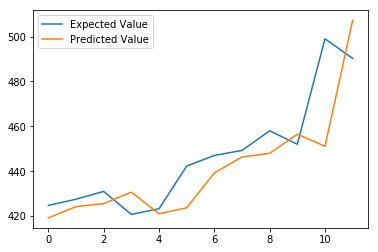

In [ ]:
# 繪圖:實際vs預測
pyplot.plot(close_values[-12:], label = 'Expected Value')
pyplot.plot(predictions, label = 'Predicted Value')
pyplot.legend()
pyplot.show()